# A recommendation system provides suggestions to the users through a filtering process that is based on user preferences and browsing history. The information about the user is taken as an input. The information is taken from the input that is in the form of browsing data. This information reflects the prior usage of the product as well as the assigned ratings. A recommendation system is a platform that provides its users with various contents based on their preferences and likings. A recommendation system takes the information about the user as an input. The recommendation system is an implementation of the machine learning algorithms.

> Indented block



# Installing necessary packages

In [ ]:
install.packages("recommenderlab")
install.packages("ggplot2")
install.packages("data.table")
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘float’, ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’, ‘matrixStats’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [ ]:
library(recommenderlab)
library(ggplot2)
library(data.table)
library(reshape2)

Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: registry

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy


Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last




We will now retrieve our data from movies.csv into movie_data dataframe and ratings.csv into rating_data. We will use the str() function to display information about the movie_data dataframe.

# Extracting data

In [ ]:
movie_data <- read.csv("movies.csv",stringsAsFactors=FALSE)
rating_data <- read.csv("ratings.csv")
str(movie_data)

'data.frame':	10329 obs. of  3 variables:
 $ movieId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title  : chr  "Toy Story (1995)" "Jumanji (1995)" "Grumpier Old Men (1995)" "Waiting to Exhale (1995)" ...
 $ genres : chr  "Adventure|Animation|Children|Comedy|Fantasy" "Adventure|Children|Fantasy" "Comedy|Romance" "Comedy|Drama|Romance" ...


In [ ]:
summary(movie_data)

    movieId          title              genres         
 Min.   :     1   Length:10329       Length:10329      
 1st Qu.:  3240   Class :character   Class :character  
 Median :  7088   Mode  :character   Mode  :character  
 Mean   : 31924                                        
 3rd Qu.: 59900                                        
 Max.   :149532                                        

In [ ]:
summary(rating_data)

     userId         movieId           rating        timestamp        
 Min.   :  1.0   Min.   :     1   Min.   :0.500   Min.   :8.286e+08  
 1st Qu.:192.0   1st Qu.:  1073   1st Qu.:3.000   1st Qu.:9.711e+08  
 Median :383.0   Median :  2497   Median :3.500   Median :1.115e+09  
 Mean   :364.9   Mean   : 13381   Mean   :3.517   Mean   :1.130e+09  
 3rd Qu.:557.0   3rd Qu.:  5991   3rd Qu.:4.000   3rd Qu.:1.275e+09  
 Max.   :668.0   Max.   :149532   Max.   :5.000   Max.   :1.452e+09  

,userId,movieId,rating,timestamp
,<int>,<int>,<dbl>,<int>
1,1,16,4.0,1217897793
2,1,24,1.5,1217895807
3,1,32,4.0,1217896246
4,1,47,4.0,1217896556
5,1,50,4.0,1217896523
6,1,110,4.0,1217896150


From the above table, we observe that the userId column, as well as the movieId column, consist of integers. Furthermore, we need to convert the genres present in the movie_data dataframe into a more usable format by the users. In order to do so, we will first create a one-hot encoding to create a matrix that comprises of corresponding genres for each of the films.

# Coverting Data into useful

In [ ]:
movie_genre <- as.data.frame(movie_data$genres, stringsAsFactors=FALSE)
library(data.table)
movie_genre2 <- as.data.frame(tstrsplit(movie_genre[,1], '[|]', 
                                   type.convert=TRUE), 
                         stringsAsFactors=FALSE) #DataFlair
colnames(movie_genre2) <- c(1:10)

list_genre <- c("Action", "Adventure", "Animation", "Children", 
                "Comedy", "Crime","Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery","Romance",
                "Sci-Fi", "Thriller", "War", "Western")
genre_mat1 <- matrix(0,10330,18)
genre_mat1[1,] <- list_genre
colnames(genre_mat1) <- list_genre

for (index in 1:nrow(movie_genre2)) {
  for (col in 1:ncol(movie_genre2)) {
    gen_col = which(genre_mat1[1,] == movie_genre2[index,col]) #Author DataFlair
    genre_mat1[index+1,gen_col] <- 1
}
}
genre_mat2 <- as.data.frame(genre_mat1[-1,], stringsAsFactors=FALSE) #remove first row, which was the genre list
for (col in 1:ncol(genre_mat2)) {
  genre_mat2[,col] <- as.integer(genre_mat2[,col]) #convert from characters to integers
} 
str(genre_mat2)

'data.frame':	10329 obs. of  18 variables:
 $ Action     : int  0 0 0 0 0 1 0 0 1 1 ...
 $ Adventure  : int  1 1 0 0 0 0 0 1 0 1 ...
 $ Animation  : int  1 0 0 0 0 0 0 0 0 0 ...
 $ Children   : int  1 1 0 0 0 0 0 1 0 0 ...
 $ Comedy     : int  1 0 1 1 1 0 1 0 0 0 ...
 $ Crime      : int  0 0 0 0 0 1 0 0 0 0 ...
 $ Documentary: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Drama      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ Fantasy    : int  1 1 0 0 0 0 0 0 0 0 ...
 $ Film-Noir  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Horror     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Musical    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Mystery    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Romance    : int  0 0 1 1 0 0 1 0 0 0 ...
 $ Sci-Fi     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Thriller   : int  0 0 0 0 0 1 0 0 0 1 ...
 $ War        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Western    : int  0 0 0 0 0 0 0 0 0 0 ...


we will create a ‘search matrix’ that will allow us to perform an easy search of the films by specifying the genre present in our list.

In [ ]:
SearchMatrix <- cbind(movie_data[,1:2], genre_mat2[])
head(SearchMatrix)    #DataFlair

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
5,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,Heat (1995),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


For our movie recommendation system to make sense of our ratings through recommenderlabs, we have to convert our matrix into a sparse matrix one

In [ ]:
ratingMatrix <- dcast(rating_data, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingMatrix <- as.matrix(ratingMatrix[,-1]) #remove userIds
#Convert rating matrix into a recommenderlab sparse matrix
ratingMatrix <- as(ratingMatrix, "realRatingMatrix")
ratingMatrix

Warning message in dcast(rating_data, userId ~ movieId, value.var = "rating", na.rm = FALSE):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(rating_data). In the next version, this warning will become an error.”


668 x 10325 rating matrix of class ‘realRatingMatrix’ with 105339 ratings.

In [ ]:
recommendation_model <- recommenderRegistry$get_entries(dataType = "realRatingMatrix")
names(recommendation_model)

[1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"

In [ ]:
lapply(recommendation_model, "[[", "description")

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

In [ ]:
recommendation_model$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

Collaborative Filtering involves suggesting movies to the users that are based on collecting preferences from many other users. For example, if a user A likes to watch action films and so does user B, then the movies that the user B will watch in the future will be recommended to A and vice-versa. Therefore, recommending movies is dependent on creating a relationship of similarity between the two users. With the help of recommenderlab, we can compute similarities using various operators like cosine, pearson as well as jaccard

# Creating similarity matrix

,1,2,3,4
1,0.0000000,0.9760860,0.9641723,0.9914398
2,0.9760860,0.0000000,0.9925732,0.9374253
3,0.9641723,0.9925732,0.0000000,0.9888968
4,0.9914398,0.9374253,0.9888968,0.0000000


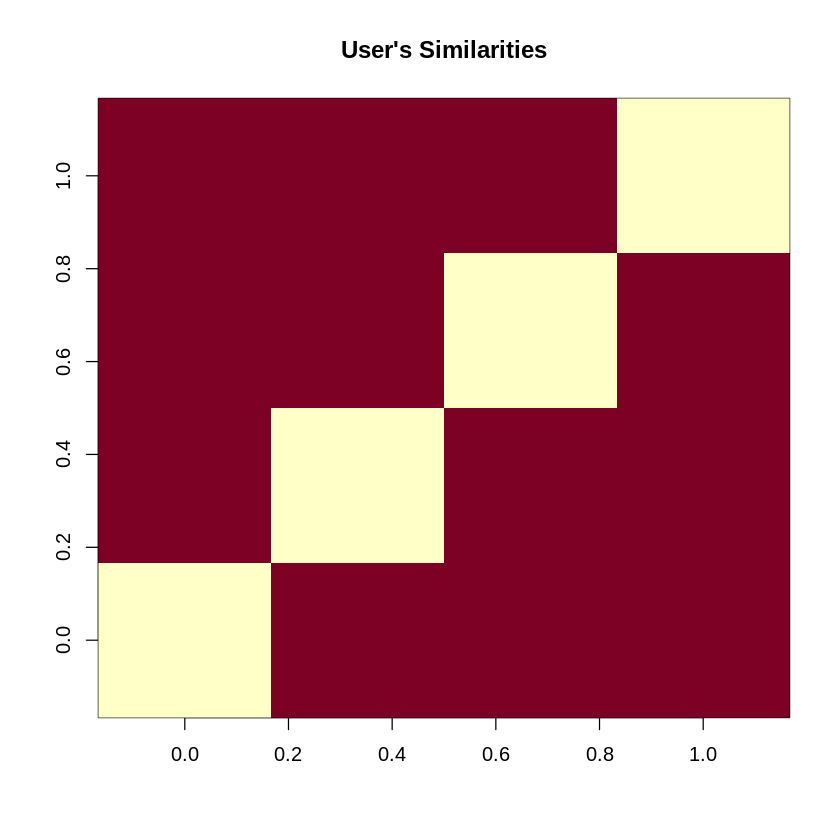

In [ ]:
similarity_mat <- similarity(ratingMatrix[1:4, ],
                               method = "cosine",
                               which = "users")
as.matrix(similarity_mat)

image(as.matrix(similarity_mat), main = "User's Similarities")

,1,2,3,4
1,0.0000000,0.9669732,0.9559341,0.9101276
2,0.9669732,0.0000000,0.9658757,0.9412416
3,0.9559341,0.9658757,0.0000000,0.9864877
4,0.9101276,0.9412416,0.9864877,0.0000000


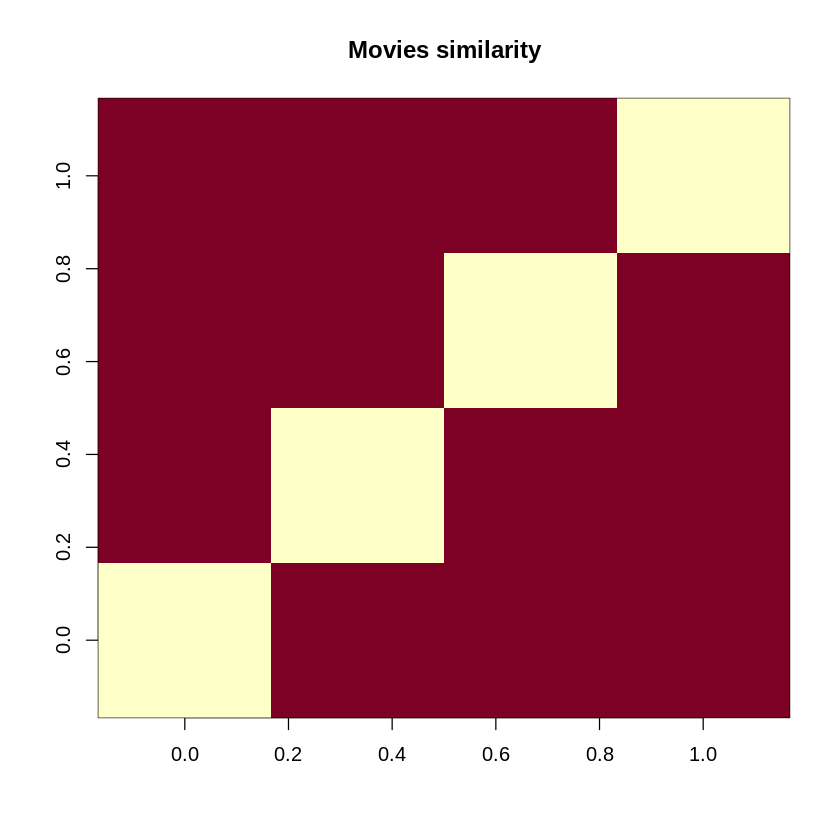

In [ ]:
movie_similarity <- similarity(ratingMatrix[, 1:4], method =
                                 "cosine", which = "items")
as.matrix(movie_similarity)

image(as.matrix(movie_similarity), main = "Movies similarity")

In [ ]:
rating_values <- as.vector(ratingMatrix@data)
unique(rating_values) # extracting unique ratings

[1] 0.0 5.0 4.0 3.0 4.5 1.5 2.0 3.5 1.0 2.5 0.5

table of ratings that will display the most unique ratings.

In [ ]:
Table_of_Ratings <- table(rating_values) # creating a count of movie ratings
Table_of_Ratings

rating_values
      0     0.5       1     1.5       2     2.5       3     3.5       4     4.5 
6791761    1198    3258    1567    7943    5484   21729   12237   28880    8187 
      5 
  14856 

# Most Viewed Movie visualisation

first count the number of views in a film and then organize them in a table that would group them in descending order.

In [ ]:
library(ggplot2)
movie_views <- colCounts(ratingMatrix) # count views for each movie
table_views <- data.frame(movie = names(movie_views),
                          views = movie_views) # create dataframe of views
table_views <- table_views[order(table_views$views,
                                 decreasing = TRUE), ] # sort by number of views
table_views$title <- NA
for (index in 1:10325){
  table_views[index,3] <- as.character(subset(movie_data,
                                         movie_data$movieId == table_views[index,1])$title)
}
table_views[1:6,]

,movie,views,title
,<chr>,<int>,<chr>
296,296,325,Pulp Fiction (1994)
356,356,311,Forrest Gump (1994)
318,318,308,"Shawshank Redemption, The (1994)"
480,480,294,Jurassic Park (1993)
593,593,290,"Silence of the Lambs, The (1991)"
260,260,273,Star Wars: Episode IV - A New Hope (1977)


 bar plot for the total number of views of the top films

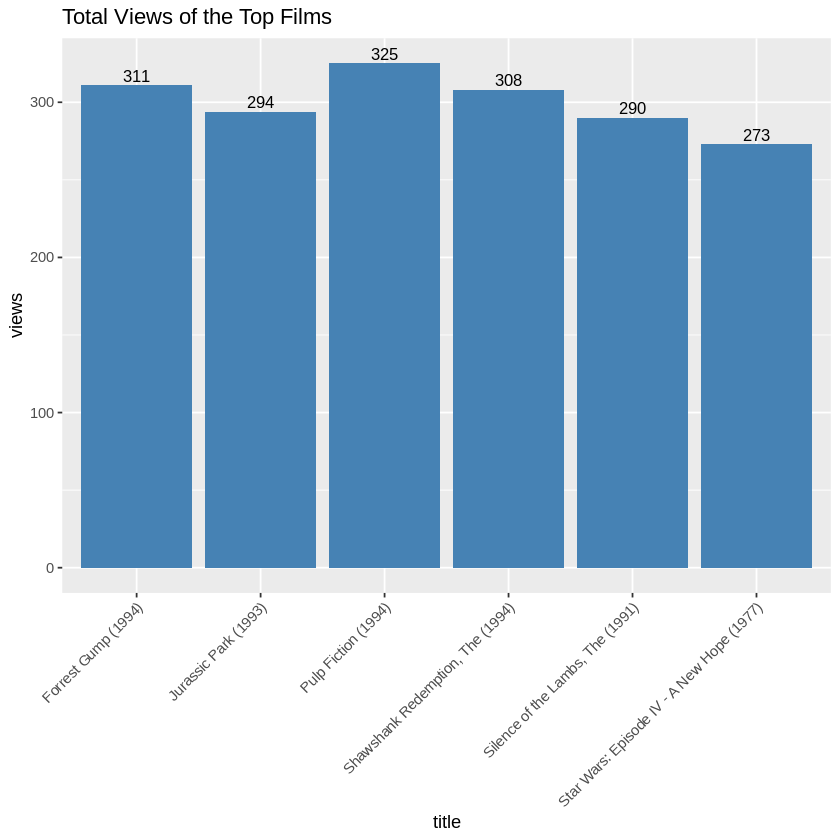

In [ ]:
ggplot(table_views[1:6, ], aes(x = title, y = views)) +
  geom_bar(stat="identity", fill = 'steelblue') +
  geom_text(aes(label=views), vjust=-0.3, size=3.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +

  ggtitle("Total Views of the Top Films")

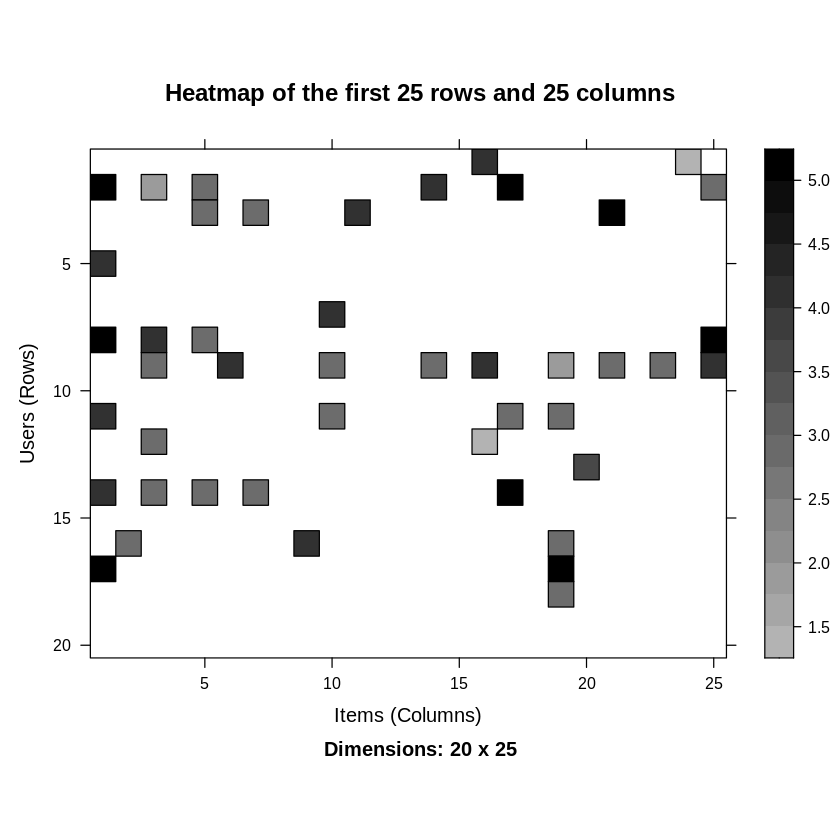

In [ ]:
image(ratingMatrix[1:20, 1:25], axes = FALSE, main = "Heatmap of the first 25 rows and 25 columns")

We will conduct data preparation in the following three steps –

* Selecting useful data.
* Normalizing data.
* Binarizing the data.

For finding useful data in our dataset, we have set the threshold for the minimum number of users who have rated a film as 50. This is also same for minimum number of views that are per film. This way, we have filtered a list of watched films from least-watched ones.

In [ ]:
movie_ratings <- ratingMatrix[rowCounts(ratingMatrix) > 50,
                             colCounts(ratingMatrix) > 50]
movie_ratings

420 x 447 rating matrix of class ‘realRatingMatrix’ with 38341 ratings.

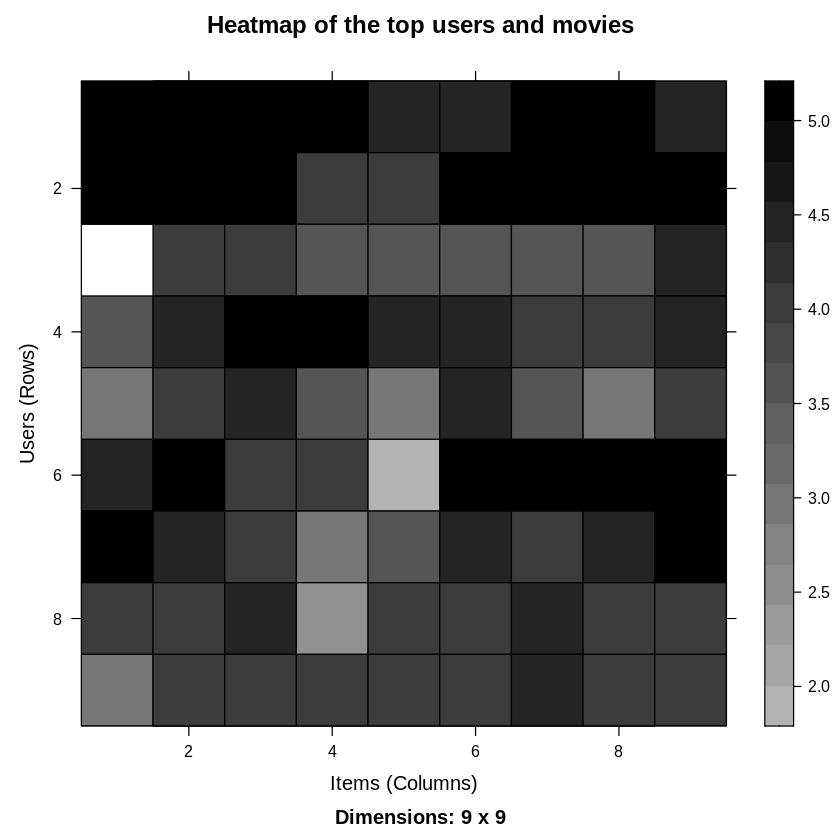

In [ ]:
minimum_movies<- quantile(rowCounts(movie_ratings), 0.98)
minimum_users <- quantile(colCounts(movie_ratings), 0.98)
image(movie_ratings[rowCounts(movie_ratings) > minimum_movies,
                     colCounts(movie_ratings) > minimum_users],
main = "Heatmap of the top users and movies")

 distribution of the average ratings per user.
 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



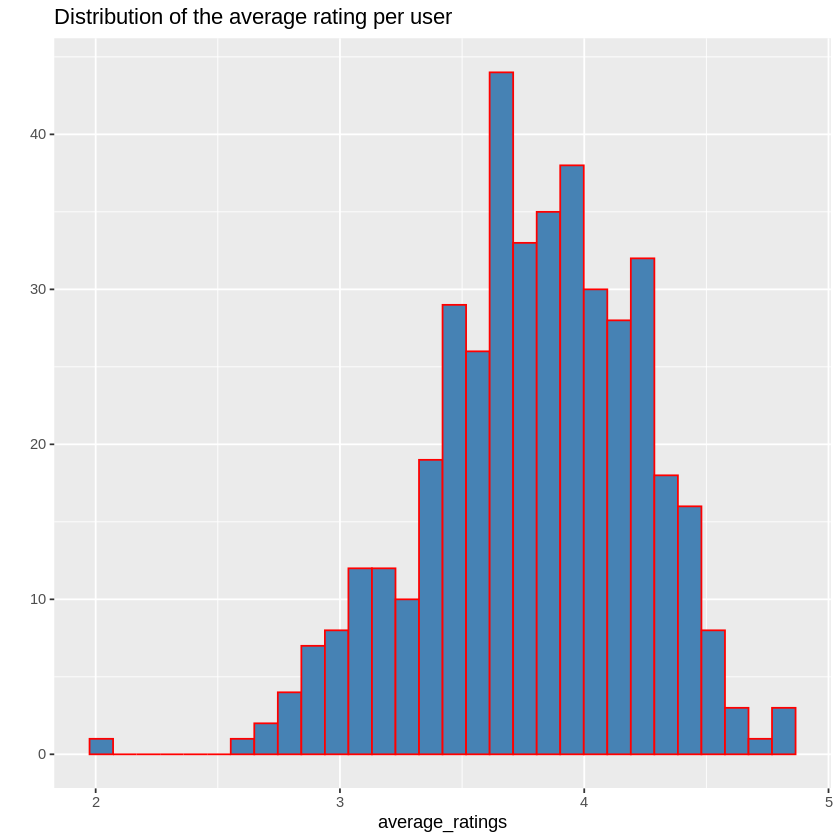

In [ ]:
average_ratings <- rowMeans(movie_ratings)
qplot(average_ratings, fill=I("steelblue"), col=I("red")) +
  ggtitle("Distribution of the average rating per user")

 there can be high ratings or low ratings provided to all of the watched films. This will act as a bias while implementing our model. In order to remove this, we normalize our data. Normalization is a data preparation procedure to standardize the numerical values in a column to a common scale value. This is done in such a way that there is no distortion in the range of values. Normalization transforms the average value of our ratings column to 0. We then plot a heatmap that delineates our normalized ratings.

[1] 0

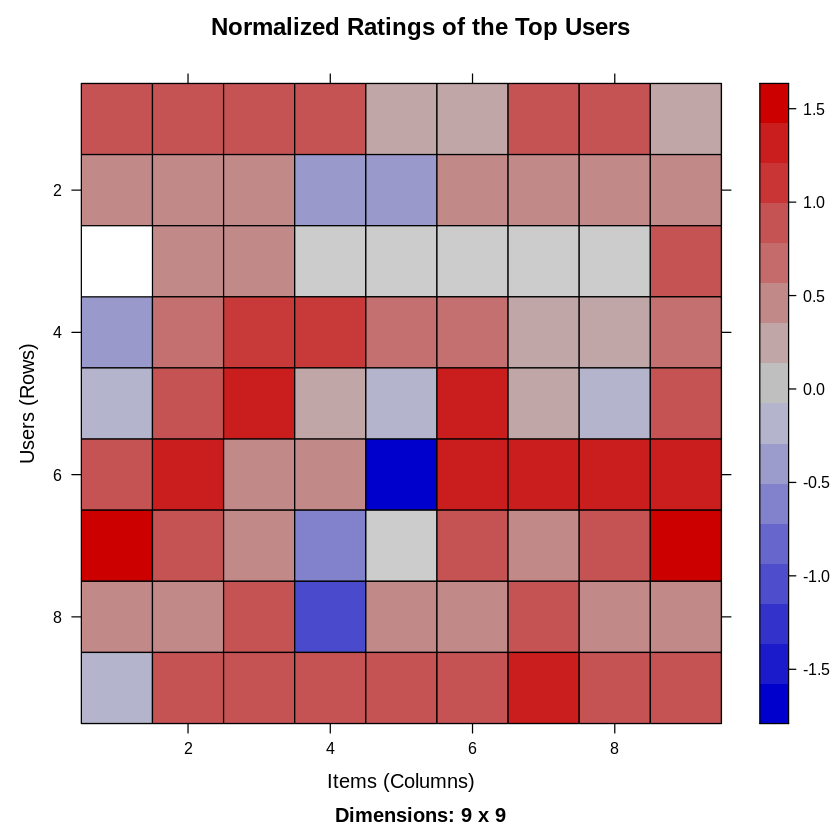

In [ ]:
normalized_ratings <- normalize(movie_ratings)
sum(rowMeans(normalized_ratings) > 0.00001)

image(normalized_ratings[rowCounts(normalized_ratings) > minimum_movies,
                          colCounts(normalized_ratings) > minimum_users],
main = "Normalized Ratings of the Top Users")

Binarizing the data means that we have two discrete values 1 and 0, which will allow our recommendation systems to work more efficiently. We will define a matrix that will consist of 1 if the rating is above 3 and otherwise it will be 0.

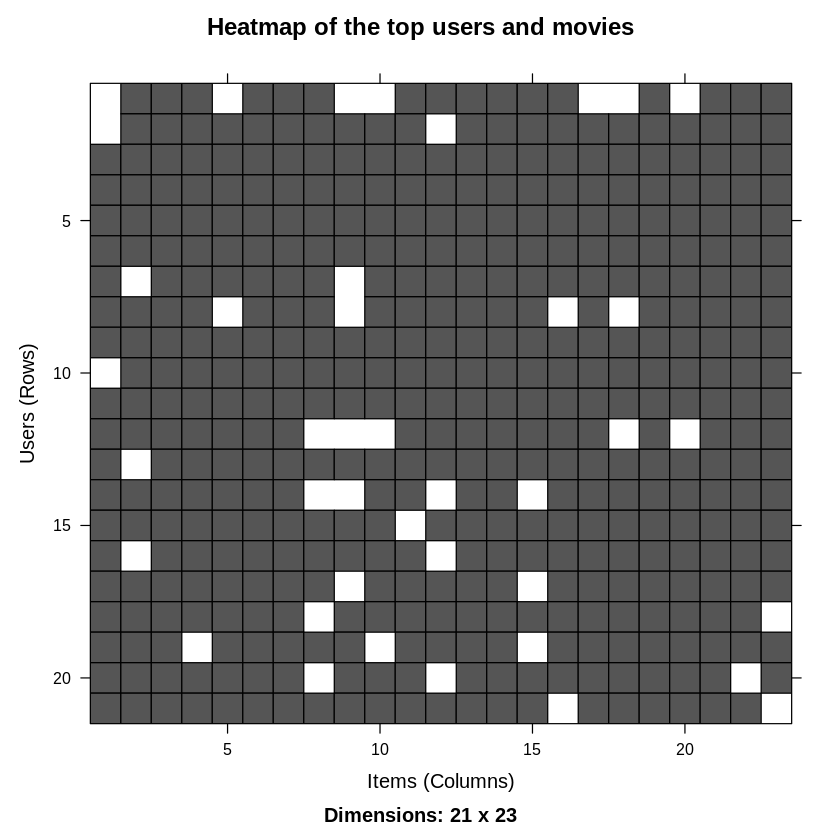

In [ ]:
binary_minimum_movies <- quantile(rowCounts(movie_ratings), 0.95)
binary_minimum_users <- quantile(colCounts(movie_ratings), 0.95)
#movies_watched <- binarize(movie_ratings, minRating = 1)

good_rated_films <- binarize(movie_ratings, minRating = 3)
image(good_rated_films[rowCounts(movie_ratings) > binary_minimum_movies,
colCounts(movie_ratings) > binary_minimum_users],
main = "Heatmap of the top users and movies")

collaborative filtering finds similarity in the items based on the people’s ratings of them. The algorithm first builds a similar-items table of the customers who have purchased them into a combination of similar items. This is then fed into the recommendation system.

The similarity between single products and related products can be determined with the following algorithm –

* For each Item i1 present in the product catalog, purchased by customer C.
* And, for each item i2 also purchased by the customer C.
* Create record that the customer purchased items i1 and i2.
* Calculate the similarity between i1 and i2.

We will build this filtering system by splitting the dataset into 80% training set and 20% test set.

In [ ]:
sampled_data<- sample(x = c(TRUE, FALSE),
                      size = nrow(movie_ratings),
                      replace = TRUE,
                      prob = c(0.8, 0.2))
training_data <- movie_ratings[sampled_data, ]
testing_data <- movie_ratings[!sampled_data, ]

# Building the Recommendation System

In [ ]:
recommendation_system <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommendation_system$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

In the first step, k denotes the number of items for computing their similarities. Here, k is equal to 30. Therefore, the algorithm will now identify the k most similar items and store their number. We use the cosine method which is the default one but you can also use pearson method.

In [ ]:
recommen_model <- Recommender(data = training_data,
                          method = "IBCF",
                          parameter = list(k = 30))
recommen_model
class(recommen_model)

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 329 users.

[1] "Recommender"
attr(,"package")
[1] "recommenderlab"

Using the getModel() function, we will retrieve the recommen_model. We will then find the class and dimensions of our similarity matrix that is contained within model_info. Finally, we will generate a heatmap, that will contain the top 20 items and visualize the similarity shared between them

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] 447 447

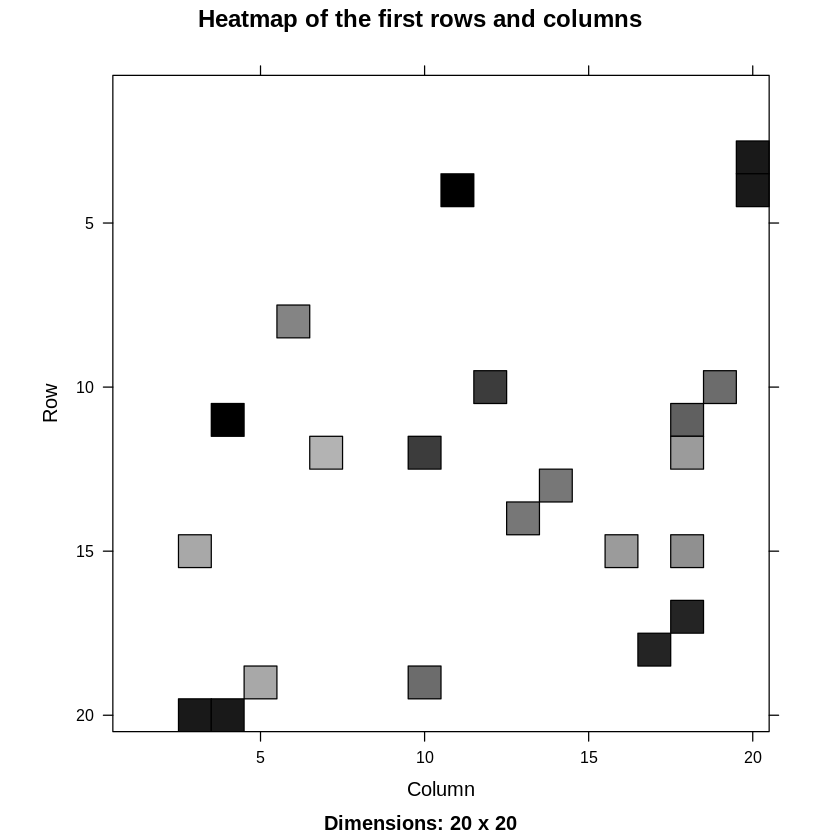

In [ ]:
model_info <- getModel(recommen_model)
class(model_info$sim)
dim(model_info$sim)
top_items <- 20
image(model_info$sim[1:top_items, 1:top_items],
   main = "Heatmap of the first rows and columns")

we will carry out the sum of rows and columns with the similarity of the objects above 0. 

sum_rows
 30 
447 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



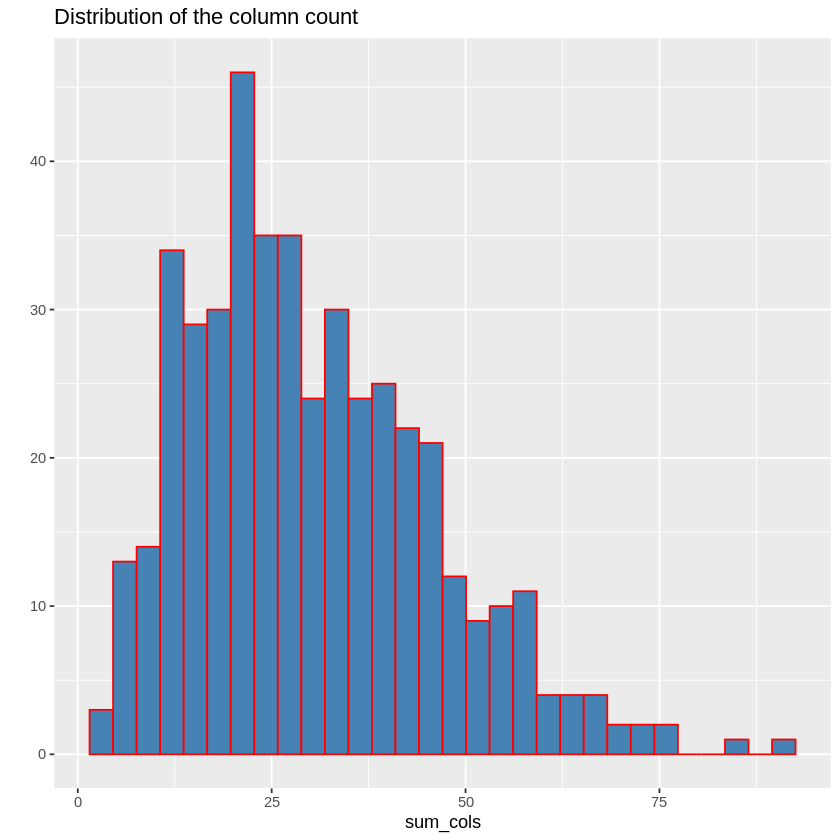

In [ ]:
sum_rows <- rowSums(model_info$sim > 0)
table(sum_rows)

sum_cols <- colSums(model_info$sim > 0)
qplot(sum_cols, fill=I("steelblue"), col=I("red"))+ ggtitle("Distribution of the column count")

top_recommendations variable which will be initialized to 10, specifying the number of films to each user. We will then use the predict() function that will identify similar items and will rank them appropriately. Here, each rating is used as a weight. Each weight is multiplied with related similarities. Finally, everything is added in the end.

In [ ]:
top_recommendations <- 10 # the number of items to recommend to each user
predicted_recommendations <- predict(object = recommen_model,
                          newdata = testing_data,
                          n = top_recommendations)
predicted_recommendations

Recommendations as ‘topNList’ with n = 10 for 91 users. 

In [ ]:
user1 <- predicted_recommendations@items[[1]] # recommendation for the first user
movies_user1 <- predicted_recommendations@itemLabels[user1]
movies_user2 <- movies_user1
for (index in 1:10){
  movies_user2[index] <- as.character(subset(movie_data,
                                         movie_data$movieId == movies_user1[index])$title)
}
movies_user2

[1] "Toy Story (1995)"                                                           
 [2] "Casino (1995)"                                                              
 [3] "Twelve Monkeys (a.k.a. 12 Monkeys) (1995)"                                  
 [4] "Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)"
 [5] "Trainspotting (1996)"                                                       
 [6] "Vertigo (1958)"                                                             
 [7] "North by Northwest (1959)"                                                  
 [8] "Casablanca (1942)"                                                          
 [9] "Fish Called Wanda, A (1988)"                                                
[10] "Reservoir Dogs (1992)"

In [ ]:
recommendation_matrix <- sapply(predicted_recommendations@items,
                      function(x){ as.integer(colnames(movie_ratings)[x]) }) # matrix with the recommendations for each user
#dim(recc_matrix)
recommendation_matrix[,1:4]

1,39,1639,6
16,158,5418,2804
32,235,2329,4995
750,292,457,48394
778,357,364,1097
903,364,1729,596
908,440,110,1307
912,708,5989,3996
1079,724,161,1704
1089,1028,1221,1682
